# Part 1: Baseline Evaluation

## Business Context
- **Problem**: 22% of products are returned, costing $18 per return (~$400K/month)
- **Opportunity**: Predict returns and apply ($3 per order) interventions that reduce return probability by 35%
- **Goal**: Identify high-risk orders for targeted intervention

## Critical Insight from Baseline Model
The baseline model has **0% recall on returns** - it predicts ALL orders as "kept".

This is completely useless for our business case: we need to CATCH returns to intervene.

The baseline results show a **catastrophic failure**:
- Recall on returns = 0% (catches NO returns)
- The model simply predicts "kept" for everything
- This happens due to class imbalance (78% kept vs 22% returned)

From the bussiness impact we can see is expensiest use the actual model comparign without the model.

## Metric Selection Justification

| Metric | Why It Matters | Priority | Target |
|--------|---------------|----------|--------|
| **Recall (Returns)** | Each missed return costs $18. We MUST catch returns. | HIGH | > 50% |
| **Precision (Returns)** | Unnecessary interventions cost $3. Less critical due to cost asymmetry. | MEDIUM | > 50% |
| **PR-AUC** | Better than ROC-AUC for imbalanced data, focuses on minority class | HIGH | > 0.40 |
| **Business Savings** | Ultimate measure of model value | CRITICAL | > $0 |


With these metrics, we prioritize catching returns, minimizing unnecessary interventions, and maximizing savings knowing that we need a model with a minimum precision for profitability: 47.6%.

In [1]:
from functions import *
import joblib
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [7]:
RETURN_COST = 18              # Cost per return ($)
INTERVENTION_COST = 3         # Cost per intervention ($)
INTERVENTION_EFFECT = 0.35    # Reduction in return probability (35%)
MONTHLY_ORDERS = 400000 / (0.22 * 18)  # Estimated monthly orders (~101K)

In [10]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model = joblib.load("baseline_model.pkl")

train = pd.read_csv('ecommerce_returns_train.csv')
test = pd.read_csv('ecommerce_returns_test.csv')

train.head()

,order_id,customer_age,customer_tenure_days,product_category,product_price,days_since_last_purchase,previous_returns,product_rating,discount_applied,size_purchased,is_return
0,2117,32,214,Fashion,12.47,9,1,3.4,1,M,0
1,6878,26,79,Fashion,76.46,91,1,3.9,0,L,0
2,5447,18,103,Electronics,23.07,51,1,3.8,0,NaN,0
3,448,23,269,Fashion,21.18,4,0,4.8,1,M,1
4,2583,34,12,Electronics,19.97,12,1,4.5,1,NaN,0


In [4]:
X_train, y_train = preprocess(train)
X_test, y_test = preprocess(test)

y_pred = model.predict(X_test)

baseline_metrics = calculate_business_metrics(y_test, y_pred)

In [5]:
print("\n Classification Metrics:")
print(f"   Recall (Returns):    {baseline_metrics['Recall (Returns)']:.2%}") # % of actual returns we catch - MOST IMPORTANT
print(f"   Precision (Returns): {baseline_metrics['Precision (Returns)']:.2%}") # % of predicted returns that are actual returns
print(f"   F1-Score (Returns):  {baseline_metrics['F1-Score (Returns)']:.2%}") # 

print("\n Business Impact:")
print(f"   Returns Caught:      {baseline_metrics['True Positives']:,} / {505}") # 505 is from the classification report from the baseline model
print(f"   Returns Missed:      {baseline_metrics['False Negatives']:,}")
print(f"   Cost Without Model:  ${baseline_metrics['Cost Without Model ($)']:,.2f}")
print(f"   Cost With Model:     ${baseline_metrics['Cost With Model ($)']:,.2f}")
print(f"   Total Savings:       ${baseline_metrics['Total Savings ($)']:,.2f}")


 Classification Metrics:
   Recall (Returns):    7.33%
   Precision (Returns): 29.13%
   F1-Score (Returns):  11.71%

 Business Impact:
   Returns Caught:      37 / 505
   Returns Missed:      468
   Cost Without Model:  $9,090.00
   Cost With Model:     $9,237.90
   Total Savings:       $-147.90


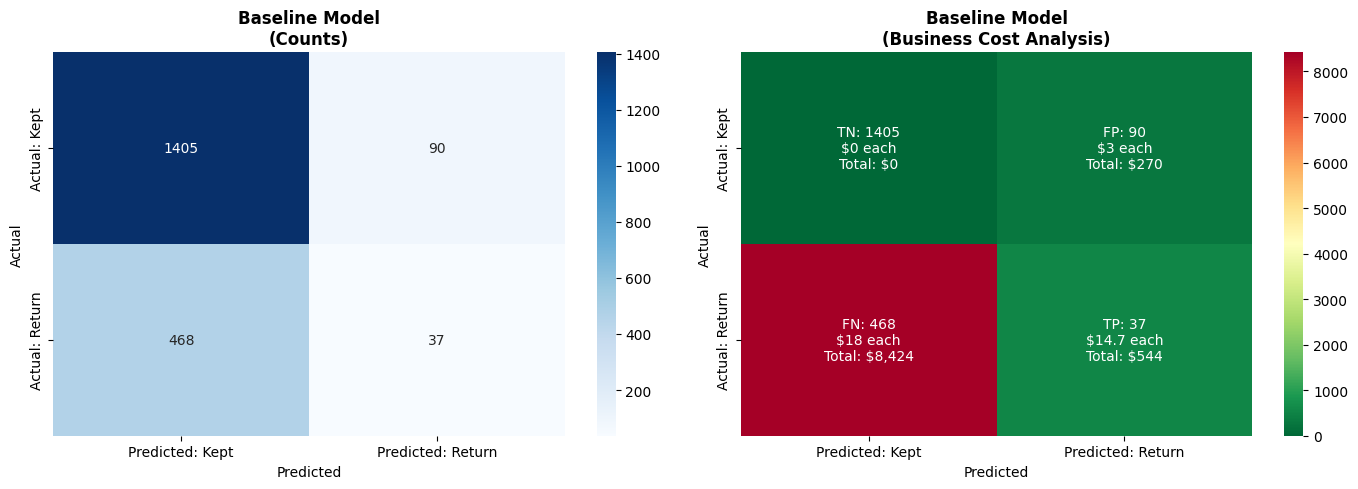


📋 CONFUSION MATRIX INTERPRETATION:
--------------------------------------------------
• True Negatives (TN):  1,405 - Correctly predicted as kept (no cost)
• False Positives (FP): 90 - Wrongly flagged for intervention ($3/each)
• False Negatives (FN): 468 - MISSED RETURNS ($18/each) ← BIGGEST PROBLEM
• True Positives (TP):  37 - Caught returns (reduced cost)


In [6]:
plot_confusion_matrix_detailed(y_test, y_pred, "Baseline Model")

In [9]:
# New metrics:

savings_per_tp = RETURN_COST - (INTERVENTION_COST + RETURN_COST * (1 - INTERVENTION_EFFECT))
cost_per_fp = INTERVENTION_COST

print(f"   Cost of missing a return (FN):     ${RETURN_COST}")
print(f"   Cost of unnecessary intervention:  ${cost_per_fp}")
print(f"   Savings per caught return (TP):    ${savings_per_tp:.2f}")
print(f"   Cost ratio (FN/FP):                {RETURN_COST/cost_per_fp:.1f}x")
print(f"\n   → We can accept up to {RETURN_COST/cost_per_fp:.0f} false alarms per caught return!")

min_precision = cost_per_fp / (savings_per_tp + cost_per_fp)
print(f"\n   → Minimum precision for profitability: {min_precision:.1%}")

   Cost of missing a return (FN):     $18
   Cost of unnecessary intervention:  $3
   Savings per caught return (TP):    $3.30
   Cost ratio (FN/FP):                6.0x

   → We can accept up to 6 false alarms per caught return!

   → Minimum precision for profitability: 47.6%
